# Preprocessing Raw data and some EDA

In [13]:
import lamindb as ln
import bionty as bt

In [14]:
ln.track()

→ updated transform description, loaded Transform('s1mQjeFWxjJI0000'), re-started Run('QzqBH3QA...') at 2025-03-06 13:46:19 UTC
→ notebook imports: anndata==0.11.3 bionty==1.1.0 lamindb==1.1a1 pandas==2.2.3 scanpy==1.11.0 scipy==1.14.1 tqdm==4.67.1


In [15]:
import os
from pathlib import Path
import pandas as pd
import scanpy as sc
import anndata
import scipy.sparse as sp
from tqdm import tqdm

Anyone looking to start the analysis from raw (unfiltered) data can search the artifacts registry and retrieve the .h5ad file containing the raw counts.

In [16]:
#search
ln.Artifact.features.filter(experiment__icontains="Breast Cancer").df()

,uid,key,description,suffix,kind,otype,size,hash,n_files,n_observations,_hash_type,_key_is_virtual,_overwrite_versions,space_id,storage_id,schema_id,version,is_latest,run_id,created_at,created_by_id,_aux,_branch_code
id,,,,,,,,,,,,,,,,,,,,,,,
1,fqDEKvRwg55UfKxG0000,None,breast metastasis,.h5ad,dataset,AnnData,124511524,AFTJoMzP5ERzpiMqjr1qR3,None,108038,sha1-fl,True,False,1,1,None,None,True,2,2025-03-05 21:28:29.211000+00:00,1,None,1
2,NfPayTupzUQ5YEem0000,None,breast metastasis,.h5ad,dataset,AnnData,982219738,q4mdUBZZH_DE65t29RY5UG,None,117481,sha1-fl,True,False,1,1,None,None,True,2,2025-03-06 13:44:05.173000+00:00,1,None,1


In [30]:
adata_artifact = ln.Artifact.get("NfPayTupzUQ5YEem0000")

In [31]:
adata_artifact.describe()

Artifact .h5ad/AnnData
├── General
│   ├── .uid = 'NfPayTupzUQ5YEem0000'
│   ├── .size = 982219738
│   ├── .hash = 'q4mdUBZZH_DE65t29RY5UG'
│   ├── .n_observations = 117481
│   ├── .path = /Users/paulinampaiz/Desktop/myLamin_local/data/.lamindb/NfPayTupzUQ5YEem0000.h5ad
│   ├── .created_by = paupaiz
│   ├── .created_at = 2025-03-06 07:44:05
│   └── .transform = 'Schema_001.ipynb'
├── Linked features
│   └── disease                     cat[bionty.Disease]        breast cancer                            
│       author                      str                        Xu K                                     
│       experiment                  str                        Breast Cancer scRNA-seq Experiment       
└── Labels
    └── .tissues                    bionty.Tissue              breast, lymph node                       
        .diseases                   bionty.Disease             breast cancer                            
        .ulabels                    ULabel                     Raw

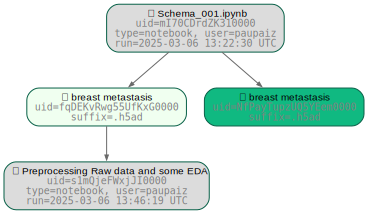

In [32]:
adata_artifact.view_lineage()

In [ ]:
adata = adata_artifact.load()
adata

### Preprocessing the dataset
---
In scRNA-seq, preprocessing typically involves quality control (QC), filtering, normalization, and transformation to remove technical artifacts and retain biologically meaningful signals.


As an analyst, starting from raw data every time can be inefficient and time-consuming. Instead, I may prefer to begin from an already preprocessed dataset, allowing me to focus more on analysis rather than repetitive data cleaning steps. To enable this, we perform quality control (QC) and preprocessing on the raw data and save it as an artifact, tagging it as "preprocessed." This ensures that future analyses can directly access a clean and structured dataset without redoing the initial steps.

To maintain consistency and interoperability, we define a schema that the dataset must adhere to after preprocessing. This schema ensures that the data contains essential columns and metadata, such as:

- Cell quality metrics (e.g., mitochondrial content, total counts, detected genes)
- Filtered gene expression values
- Cell annotations (if available)
- Batch information (if applicable)

By enforcing this structured approach, we ensure that the dataset remains well-organized, reproducible, and ready for downstream analysis, streamlining the overall workflow.

Below are some common preprocessing steps for a scRNA-seq data: 

#### A. Tagging MT genes, Mito Genes, HB genes 

In [35]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

#### B. Calculating Metrics based on the taggings:  

In [36]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

#### C. Plotting Metrics

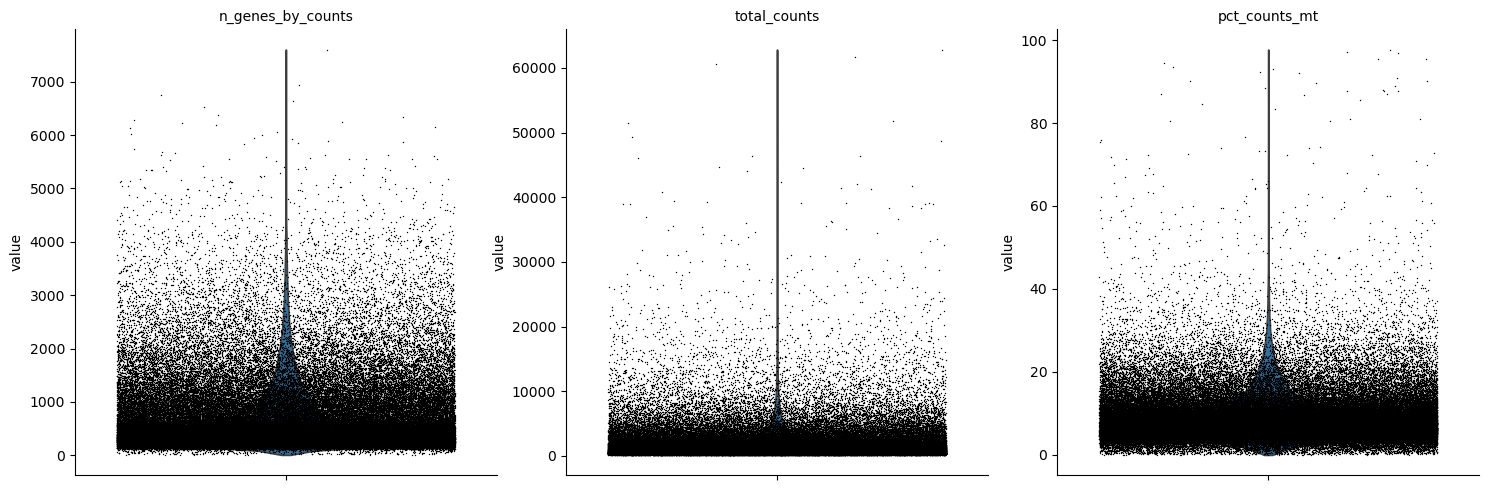

In [37]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

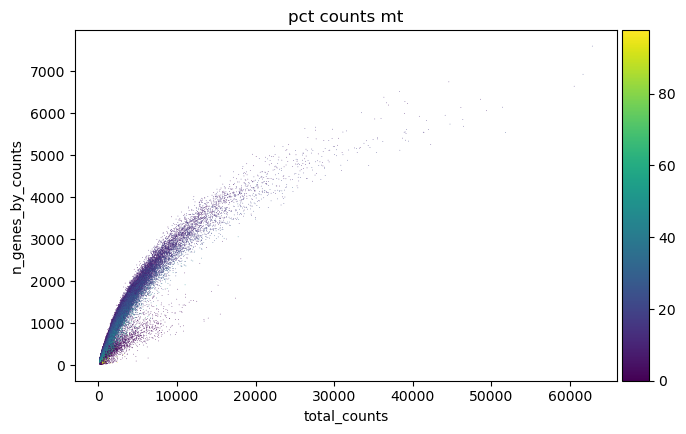

In [38]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

#### D. Defining and applying Filters

In [39]:
# Define filtering thresholds
mt_threshold = 0.2  # Remove cells where >20% of reads are from mitochondrial genes
min_genes_per_cell = 200  # Remove cells with fewer than 200 genes
max_genes_per_cell = 2000  # Remove cells with excessive gene expression (potential doublets)
min_counts_per_cell = 1000  # Remove cells with very low total counts
max_counts_per_cell = 30000  # Remove extreme high count outliers

# Apply filters
filtered_cells = (
    (adata.obs["pct_counts_mt"] < mt_threshold * 100) &  # Mitochondrial percentage
    (adata.obs["n_genes_by_counts"] > min_genes_per_cell) &
    (adata.obs["n_genes_by_counts"] < max_genes_per_cell) &
    (adata.obs["total_counts"] > min_counts_per_cell) &
    (adata.obs["total_counts"] < max_counts_per_cell)
)

# Filter the dataset
adata = adata[filtered_cells].copy()

print(f"Remaining cells after filtering: {adata.shape[0]}")

Remaining cells after filtering: 42049


In [40]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

#### E. Normalising and transforming the counts

In [41]:
adata.layers["counts"] = adata.X.copy()

In [42]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True)

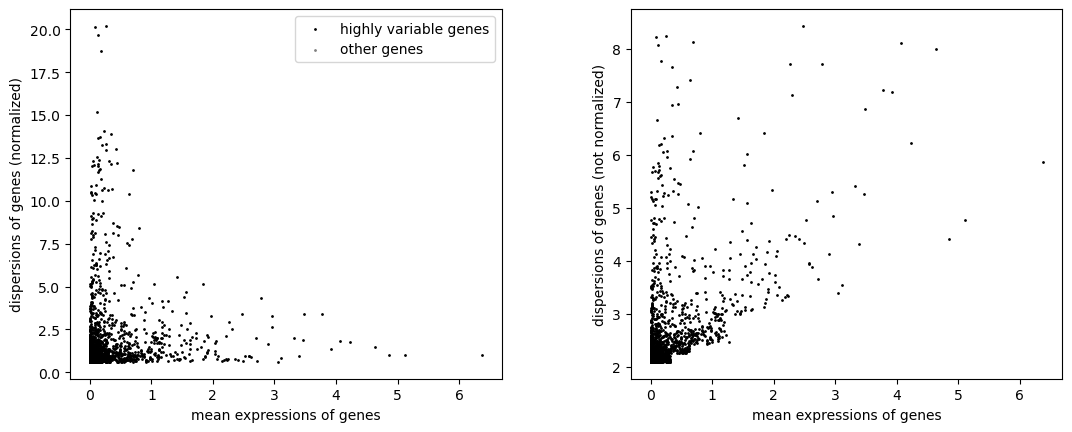

In [43]:
sc.pl.highly_variable_genes(adata)

### Saving AnnData After Preprocessing
---

After preprocessing, our `.var` and `.obs` dataframes contain additional columns, enriching the dataset with crucial metadata and annotations.

To maintain consistency and interoperability, any preprocessed dataset ingested into the LaminDB datalake must follow a predefined schema. This ensures that every analysis starts with the same essential set of information, eliminating inconsistencies and improving reproducibility.

In the next few steps, we will explore:
- How to define a schema for an AnnData object
- How to enforce schema adherence when registering an artifact

By structuring our datasets effectively, we create a standardized and interoperable data pipeline, making analysis more efficient and scalable

Let's look at the current state of our annData:

In [19]:
adata.var.head()

,mt,ribo,hb,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,highly_variable,means,dispersions,dispersions_norm
SPP1,False,False,False,2923,0.430912,0.358312,97.511938,50624,10.832201,2059,True,1.560116,6.012944,4.681798
HLA-DPB1,False,False,False,27577,0.638656,0.493877,76.526417,75030,11.225657,13625,True,1.910738,3.399993,1.125622
MT-RNR2,True,False,False,116483,34.280113,3.563319,0.849499,4027262,15.208598,41967,True,5.113736,4.774937,1.000000
IGLC2,False,False,False,27936,7.435526,2.132452,76.220836,873533,13.680302,12323,True,4.065498,8.115295,1.832363
IGLC3,False,False,False,12000,2.112044,1.135280,89.785582,248125,12.421692,5273,True,2.788179,7.707479,4.329275


In [20]:
adata.obs.head()

,patient,site,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,total_counts_ribo,log1p_total_counts_ribo,pct_counts_ribo,total_counts_hb,log1p_total_counts_hb,pct_counts_hb,n_genes
TTGCTGAAGTGC-0,P1,primary,906,6.810142,6283,8.745762,80.725768,83.893045,87.712876,93.538119,239,5.480639,3.803915,152,5.030438,2.419226,0,0.000000,0.000000,906
CGACAGGTGAGG-0,P1,primary,1850,7.523481,7304,8.896314,50.177985,58.064074,66.511501,78.628149,950,6.857514,13.006572,826,6.717805,11.308872,0,0.000000,0.000000,1850
ATCAAGCCTATT-0,P1,primary,1607,7.382746,6982,8.851234,61.400745,66.327700,72.543684,82.769980,295,5.690359,4.225150,379,5.940171,5.428244,0,0.000000,0.000000,1607
ATGCCTACATGG-0,P1,primary,779,6.659294,5448,8.603187,81.424376,84.691630,88.656388,94.878855,412,6.023448,7.562408,192,5.262690,3.524229,0,0.000000,0.000000,779
CTTATATGCTTA-0,P1,primary,1936,7.568896,6550,8.787373,38.259542,47.022901,57.038168,72.992366,506,6.228511,7.725191,394,5.978886,6.015267,4,1.609438,0.061069,1936


#### A. Defining Lables from metadata
---

In [44]:
## Defining the ULabels
## We have the following we saw a categorical and with limited set of values
patient_ulabel = ln.ULabel(name="Patient", is_type=True).save()
site_ulabel = ln.ULabel(name="Site", is_type=True).save()

In [45]:
ln.ULabel.df().head()

,uid,name,is_type,description,reference,reference_type,space_id,type_id,run_id,created_at,created_by_id,_aux,_branch_code
id,,,,,,,,,,,,,
5,xfku6xV6,Site,True,None,None,None,1,NaN,4,2025-03-06 13:50:59.203000+00:00,1,None,1
4,Gz9abIQy,Patient,True,None,None,None,1,NaN,4,2025-03-06 13:50:59.199000+00:00,1,None,1
3,dUEhzbVV,Filtered,False,None,None,None,1,1.0,2,2025-03-05 21:29:01.894000+00:00,1,None,1
2,M5nEnE6w,Raw,False,None,None,None,1,1.0,2,2025-03-05 21:29:01.889000+00:00,1,None,1
1,FDjoEpe0,Processing Stage,True,None,None,None,1,NaN,2,2025-03-05 21:28:59.960000+00:00,1,None,1


#### B. Define Features
---
Here, we will define the Features using the ULabels we have defined eariler.

`patient`, `site` and other calculated values.

In [46]:
# Note that we have defined cat features with the categorical ULabel[Patient]
# These are features for the obs dataframe
f_1 = ln.Feature(name="patient", dtype="cat[ULabel[Patient]]").save()
f_2 = ln.Feature(name="site", dtype="cat[ULabel[Site]]").save()
f_3 = ln.Feature(name="n_genes_by_counts", dtype="int").save()
f_4 = ln.Feature(name="log1p_n_genes_by_counts", dtype="float").save()

In [47]:
# These are features for the var Dataframe
f_5 = ln.Feature(name="mt", dtype="bool").save()
f_6 = ln.Feature(name="ribo", dtype="bool").save()
f_7 = ln.Feature(name="hb", dtype="bool").save()
f_8 = ln.Feature(name="n_cells_by_counts", dtype="int").save()
f_9 = ln.Feature(name="mean_counts", dtype="float").save()

We can now see the registered Features in lamindb's registry.

In [48]:
ln.Feature.df().head()

,uid,name,dtype,is_type,unit,description,array_rank,array_size,array_shape,proxy_dtype,synonyms,_expect_many,_curation,space_id,type_id,run_id,created_at,created_by_id,_aux,_branch_code
id,,,,,,,,,,,,,,,,,,,,
12,TnhPeCvLMUgk,mean_counts,float,None,None,None,0,0,None,None,None,True,None,1,None,4,2025-03-06 13:52:25.598000+00:00,1,"{'af': {'0': None, '1': None}}",1
11,2iiPAIHYQdEg,n_cells_by_counts,int,None,None,None,0,0,None,None,None,True,None,1,None,4,2025-03-06 13:52:25.596000+00:00,1,"{'af': {'0': None, '1': None}}",1
10,N6F8gjamCieI,hb,bool,None,None,None,0,0,None,None,None,True,None,1,None,4,2025-03-06 13:52:25.594000+00:00,1,"{'af': {'0': None, '1': None}}",1
9,jp3FDPIzV9ip,ribo,bool,None,None,None,0,0,None,None,None,True,None,1,None,4,2025-03-06 13:52:25.591000+00:00,1,"{'af': {'0': None, '1': None}}",1
8,S14pE1VtjkvC,mt,bool,None,None,None,0,0,None,None,None,True,None,1,None,4,2025-03-06 13:52:25.588000+00:00,1,"{'af': {'0': None, '1': None}}",1


An AnnData object looks like this, where we define the **schema** for the `.obs` and `.var` dataframes:  

<img src="https://raw.githubusercontent.com/scverse/anndata/main/docs/_static/img/anndata_schema.svg" alt="AnnData Schema" width="600">


#### C. Define Schema for Obs DataFrame

In [49]:
# Obs Dataframe Schema
obs_schema = ln.Schema(
    name="Obs Dataframe Schema after preprocessing",
    otype="DataFrame",
    features=[
        f_1,
        f_2,
        f_3,
        f_4
    ],
    coerce_dtype=True
).save()

#### D. Define Schema for Var DataFrame

In [50]:
var_schema = ln.Schema(
    name="Var Dataframe Schema after preprocessing",
    otype="DataFrame",
    features=[
        f_5,
        f_6,
        f_7,
        f_8,
        f_9
    ],
    coerce_dtype=True
).save()

#### E. Define Schema for AnnData

In [51]:
adata_schema = ln.Schema(
    name="Preprocessed AnnData schema",
    otype="AnnData",
    components={
        "obs":obs_schema,
        "var":var_schema
    }
).save()

### Ensuring Datasets Adhere to a Schema
---
Now that we have defined a schema, we want to ensure that all preprocessed datasets conform to it, maintaining consistency and standardization across analyses.

We achieve this using the curator method in LaminDB, which validates whether the values in the dataset align with the defined schema constraints. This ensures that:

- Required columns and metadata are present
- Data types and value ranges are consistent
- The dataset structure remains uniform across different analyses

#### A. Define a curator object using the dataset(AnnData) and schema

In [52]:
curator = ln.curators.AnnDataCurator(
    adata,
    adata_schema
)

In [53]:
try:
    curator.validate()
except ln.errors.ValidationError as error:
    print(error)

• mapping "patient" on ULabel.name
!   5 terms are not validated: 'P1', 'P2', 'P3', 'P4', 'P5'
    → fix typos, remove non-existent values, or save terms via .add_new_from("patient")
• mapping "site" on ULabel.name
!   3 terms are not validated: 'primary', 'LN1', 'LN2'
    → fix typos, remove non-existent values, or save terms via .add_new_from("site")
3 terms are not validated: 'primary', 'LN1', 'LN2'
    → fix typos, remove non-existent values, or save terms via .add_new_from("site")


We observe that the terms for certain fields, such as:

- patient
- site

are not yet validated.

To ensure consistency and standardization, we can assign ULabels to these features, defining them according to our expectations. Additionally, we can enhance validation and interoperability by leveraging public ontologies through Bionty, mapping these fields to standardized biomedical terminologies. This helps maintain a structured and universally interpretable dataset, improving both data quality and integration across different analyses

#### B. Defining Values for ULabels for ULable Type Patient and Site

In [54]:
## patient
for patient_name in adata.obs["patient"].unique():
    ln.ULabel(name = patient_name, type=patient_ulabel).save()

In [55]:
## patient
for site_name in adata.obs["site"].unique():
    ln.ULabel(name = site_name, type=site_ulabel).save()

#### TODO
NOTE: Check the schema defined here, mt is going into obs dataframe

In [56]:
try:
    curator.validate()
except ln.errors.ValidationError as error:
    print(error)

✓ "patient" is validated against ULabel.name
✓ "site" is validated against ULabel.name
column 'mt' not in dataframe. Columns in dataframe: ['SPP1', 'HLA-DPB1', 'MT-RNR2', 'IGLC2', 'IGLC3', 'A2M', 'FTL', 'MALAT1', 'IGKC', 'IGHG4', 'TXN', 'HSP90AA1', 'S100P', 'CXCL9', 'IGLC7', 'RGS1', 'RPS27', 'APOC1', 'COL3A1', 'TYROBP', 'IGHG1', 'CD74', 'IGHM', 'ETFBKMT', 'CD2', 'CST3', 'CCL4L2', 'CCL4', 'S100A8', 'TREM1', 'BEX5', 'ISG15', 'SRGN', 'IGFBP7', 'IKZF2', 'GPNMB', 'CAMP', 'HLA-DRB6', 'RNU2-63P', 'S100A4', 'IFI27', 'C3', 'ID2', 'CILP', 'INHBA', 'CEP55', 'PRSS23', 'CCL5', 'C1S', 'PALMD', 'ARAP2', 'PDE4B', 'SFRP2', 'CCR7', 'BIRC3', 'COL1A2', 'MX1', 'APOD', 'SGK1', 'EREG', 'BTG2', 'MT1X', 'ANXA1', 'AIF1', 'HLA-DPA1', 'C1R', 'IGHV1-69', 'CPVL', 'TRMT10B', 'MZB1', 'LY86', 'IFI44L', 'RNASE1', 'IL7R', 'LGALS1', 'GPR183', 'MMP7', 'AREG', 'SAMSN1', 'EEF1A1P3', 'MGP', 'MS4A7', 'CSTB', 'ZNF331', 'MYLK', 'FLT1', 'TEX9', 'TNFSF10', 'MT1F', 'CCL2', 'TNIP3', 'ADM', 'RF00003', 'MUCL1', 'AL357060.1', 'CREM', 

In [34]:
# preprocessed_adata_artifact = curator.save_artifact(
#     description="Single Cell RNA-seq dataset from GEO [GSE180286], preprocessed and filtered data"
# ).save()

In [57]:
preprocssed_adata_artifact = ln.Artifact.from_anndata(
    adata,
    description="Single Cell RNA-seq dataset from GEO [GSE180286], preprocessed and filtered data"
).save()

• path content will be copied to default storage upon `save()` with key `None` ('.lamindb/RBne2GLn0c2Kie4m0000.h5ad')
✓ storing artifact 'RBne2GLn0c2Kie4m0000' at '/Users/paulinampaiz/Desktop/myLamin_local/data/.lamindb/RBne2GLn0c2Kie4m0000.h5ad'


In [58]:
preprocssed_adata_artifact.describe()

Artifact .h5ad/AnnData
└── General
    ├── .uid = 'RBne2GLn0c2Kie4m0000'
    ├── .size = 88714646
    ├── .hash = 'I1T5VMQKYd8saSGwJQaBbF'
    ├── .n_observations = 42049
    ├── .path = /Users/paulinampaiz/Desktop/myLamin_local/data/.lamindb/RBne2GLn0c2Kie4m0000.h5ad
    ├── .created_by = paupaiz
    ├── .created_at = 2025-03-06 07:54:32
    └── .transform = 'Preprocessing Raw data and some EDA'

#### Labels

In [ ]:
## We want to now annotate it as Filtered
filtered_status = ln.ULabel.get(name="Filtered")
preprocssed_adata_artifact.ulabels.add(filtered_status)

In [61]:
preprocssed_adata_artifact.describe()

Artifact .h5ad/AnnData
├── General
│   ├── .uid = 'RBne2GLn0c2Kie4m0000'
│   ├── .size = 88714646
│   ├── .hash = 'I1T5VMQKYd8saSGwJQaBbF'
│   ├── .n_observations = 42049
│   ├── .path = /Users/paulinampaiz/Desktop/myLamin_local/data/.lamindb/RBne2GLn0c2Kie4m0000.h5ad
│   ├── .created_by = paupaiz
│   ├── .created_at = 2025-03-06 07:54:32
│   └── .transform = 'Preprocessing Raw data and some EDA'
└── Labels
    └── .ulabels                    ULabel                     Filtered

Similary we can add ULabels from bionty registry

In [62]:
# Tissue
tissue_breast = bt.Tissue.from_source(name="breast").save()
tissue_lymph = bt.Tissue.from_source(name="lymph node").save()

preprocssed_adata_artifact.tissues.add(tissue_breast)
preprocssed_adata_artifact.tissues.add(tissue_lymph)

# Disease 
disease = bt.Disease.from_source(name="breast cancer").save()
preprocssed_adata_artifact.diseases.add(disease)

In [63]:
preprocssed_adata_artifact.describe()

Artifact .h5ad/AnnData
├── General
│   ├── .uid = 'RBne2GLn0c2Kie4m0000'
│   ├── .size = 88714646
│   ├── .hash = 'I1T5VMQKYd8saSGwJQaBbF'
│   ├── .n_observations = 42049
│   ├── .path = /Users/paulinampaiz/Desktop/myLamin_local/data/.lamindb/RBne2GLn0c2Kie4m0000.h5ad
│   ├── .created_by = paupaiz
│   ├── .created_at = 2025-03-06 07:54:32
│   └── .transform = 'Preprocessing Raw data and some EDA'
└── Labels
    └── .tissues                    bionty.Tissue              breast, lymph node                       
        .diseases                   bionty.Disease             breast cancer                            
        .ulabels                    ULabel                     Filtered

Reusing the features we had defined earlier for this new artifact:

In [64]:
# we can now annotate our artifact
preprocssed_adata_artifact.features.add_values(
    {
        "experiment": "Breast Cancer scRNA-seq Experiment",
        "disease": disease,
        "author": "Xu K"
    }
)

Maybe we want to add a few more features:

In [65]:
ln.Feature(name="n_cells", dtype=int).save()
ln.Feature(name="n_genes", dtype=int).save()

! record with similar name exists! did you mean to load it?


,uid,name,dtype,is_type,unit,description,array_rank,array_size,array_shape,proxy_dtype,synonyms,_expect_many,_curation,space_id,type_id,run_id,created_at,created_by_id,_aux,_branch_code
id,,,,,,,,,,,,,,,,,,,,
11,2iiPAIHYQdEg,n_cells_by_counts,int,None,None,None,0,0,None,None,None,True,None,1,None,4,2025-03-06 13:52:25.596000+00:00,1,"{'af': {'0': None, '1': None}}",1


! records with similar names exist! did you mean to load one of them?


,uid,name,dtype,is_type,unit,description,array_rank,array_size,array_shape,proxy_dtype,synonyms,_expect_many,_curation,space_id,type_id,run_id,created_at,created_by_id,_aux,_branch_code
id,,,,,,,,,,,,,,,,,,,,
6,81V4dhYQp8ZW,n_genes_by_counts,int,None,None,None,0,0,None,None,None,True,None,1,None,4,2025-03-06 13:52:21.972000+00:00,1,"{'af': {'0': None, '1': None}}",1
7,fbfZI1haYoGf,log1p_n_genes_by_counts,float,None,None,None,0,0,None,None,None,True,None,1,None,4,2025-03-06 13:52:21.975000+00:00,1,"{'af': {'0': None, '1': None}}",1


Feature(uid='9eoaAF4jZS8I', name='n_genes', dtype='int', array_rank=0, array_size=0, created_by_id=1, run_id=4, space_id=1, created_at=2025-03-06 13:56:54 UTC)

In [66]:
# we can now annotate our artifact
preprocssed_adata_artifact.features.add_values(
    {
        "n_cells": adata.shape[0],
        "n_genes": adata.shape[1],
    }
)

In [67]:
preprocssed_adata_artifact.describe()

Artifact .h5ad/AnnData
├── General
│   ├── .uid = 'RBne2GLn0c2Kie4m0000'
│   ├── .size = 88714646
│   ├── .hash = 'I1T5VMQKYd8saSGwJQaBbF'
│   ├── .n_observations = 42049
│   ├── .path = /Users/paulinampaiz/Desktop/myLamin_local/data/.lamindb/RBne2GLn0c2Kie4m0000.h5ad
│   ├── .created_by = paupaiz
│   ├── .created_at = 2025-03-06 07:54:32
│   └── .transform = 'Preprocessing Raw data and some EDA'
├── Linked features
│   └── disease                     cat[bionty.Disease]        breast cancer                            
│       author                      str                        Xu K                                     
│       experiment                  str                        Breast Cancer scRNA-seq Experiment       
│       n_cells                     int                        42049                                    
│       n_genes                     int                        2000                                     
└── Labels
    └── .tissues                    bionty.Tissue              breast, lymph node                       
        .diseases                   bionty.Disease             breast cancer                            
        .ulabels                    ULabel                     Filtered

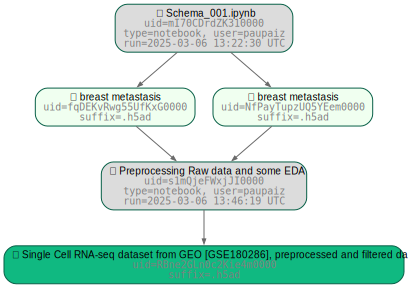

In [68]:
preprocssed_adata_artifact.view_lineage()

In [69]:
ln.Artifact.features.filter(experiment__icontains="Breast Cancer").df()

,uid,key,description,suffix,kind,otype,size,hash,n_files,n_observations,_hash_type,_key_is_virtual,_overwrite_versions,space_id,storage_id,schema_id,version,is_latest,run_id,created_at,created_by_id,_aux,_branch_code
id,,,,,,,,,,,,,,,,,,,,,,,
1,fqDEKvRwg55UfKxG0000,None,breast metastasis,.h5ad,dataset,AnnData,124511524,AFTJoMzP5ERzpiMqjr1qR3,None,108038,sha1-fl,True,False,1,1,None,None,True,2,2025-03-05 21:28:29.211000+00:00,1,None,1
2,NfPayTupzUQ5YEem0000,None,breast metastasis,.h5ad,dataset,AnnData,982219738,q4mdUBZZH_DE65t29RY5UG,None,117481,sha1-fl,True,False,1,1,None,None,True,2,2025-03-06 13:44:05.173000+00:00,1,None,1
3,RBne2GLn0c2Kie4m0000,None,Single Cell RNA-seq dataset from GEO [GSE18028...,.h5ad,dataset,AnnData,88714646,I1T5VMQKYd8saSGwJQaBbF,None,42049,sha1-fl,True,False,1,1,None,None,True,4,2025-03-06 13:54:32.873000+00:00,1,None,1
